{'d@watdo.com': {}, 'j@watdo.com': {}, 't@watdo.com': {}, 'i@watdo.com': {}, 'o@watdo.com': {}, 'n@watdo.com': {}, 'a@watdo.com': {}, 'z@watdo.com': {}, 'g@watdo.com': {}, 'f@watdo.com': {}, 'r@watdo.com': {}, 'q@watdo.com': {}, 'x@watdo.com': {}, 's@watdo.com': {}, 'e@watdo.com': {}, 'k@watdo.com': {}, 'u@watdo.com': {}, 'p@watdo.com': {}, 'b@watdo.com': {}, 'h@watdo.com': {}, 'y@watdo.com': {}, 'c@watdo.com': {}, 'm@watdo.com': {}, 'w@watdo.com': {}, 'v@watdo.com': {}, 'l@watdo.com': {}}
{'d@watdo.com': Counter({'c@watdo.com': 12, 'e@watdo.com': 11, 't@watdo.com': 9, 'k@watdo.com': 9, 'i@watdo.com': 8, 'a@watdo.com': 8, 'q@watdo.com': 8, 'u@watdo.com': 8, 'p@watdo.com': 8, 'b@watdo.com': 8, 'm@watdo.com': 8, 'o@watdo.com': 7, 'f@watdo.com': 7, 'x@watdo.com': 7, 'y@watdo.com': 7, 'v@watdo.com': 7, 'l@watdo.com': 7, 'z@watdo.com': 6, 'g@watdo.com': 6, 'n@watdo.com': 5, 's@watdo.com': 5, 'j@watdo.com': 4, 'w@watdo.com': 2, 'r@watdo.com': 1, 'h@watdo.com': 1}), 'j@watdo.com': Counter({'v

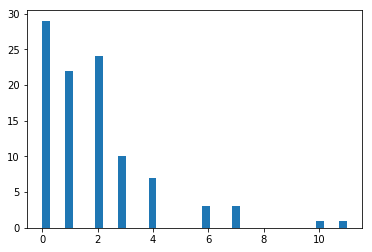

In [979]:
%matplotlib inline
import matplotlib.pyplot as plt
import string
import numpy as np
from collections import Counter
from itertools import chain

## Generate some fake users
users = {}
for x in string.ascii_lowercase:
    mail = x + "@watdo.com"
    users[mail] = {}
print(users)

## Generate fake connections, negative_binomial distributed
nedges = np.random.negative_binomial(2, 0.5, 100)
_, _, _ = plt.hist(nedges, bins=40)

for user, count in zip(users.keys(), np.random.negative_binomial(2, 0.01, len(users.keys()))):
    others = users.keys()
    others.remove(user)
    others = np.array(others)
    tos = np.random.choice(others, size=count, replace=True)
    users[user] = Counter(tos)
print(users)

<Graph object, directed, with 26 vertices and 149 edges at 0x7fd658086490>


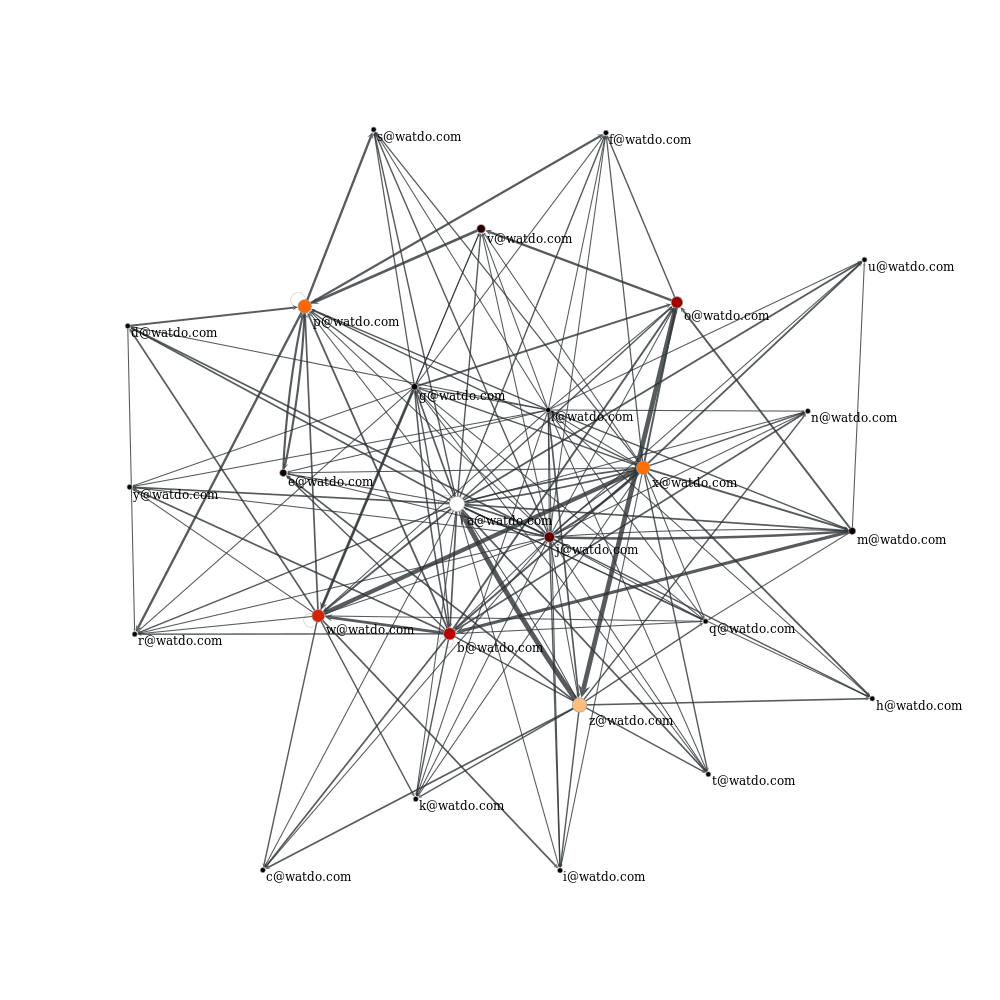

<PropertyMap object with key type 'Vertex' and value type 'vector<double>', for Graph 0x7fd658086490, at 0x7fd66c0277d0>

In [157]:
from graph_tool.all import *

g = Graph(directed=True)
labels = g.new_vertex_property("string")
for i, user in enumerate(users.keys()):
    v = g.add_vertex()
    labels[v] = user
weight = g.new_edge_property("double")

for i, user in enumerate(users.keys()):
    for j, to in enumerate(users[user].keys()):
        if users[user][to] > 10:
            e = g.add_edge(i, j)
            weight[e] = users[user][to]
vp, ep = betweenness(g, weight=weight)
print(g)
graph_draw(g, output_size=(1000, 1000), vertex_fill_color=vp,
    vertex_size=prop_to_size(vp, mi=5, ma=15),
    edge_pen_width=prop_to_size(ep, mi=0.2, ma=5),
    vcmap=plt.cm.gist_heat,
    vorder=vp,
    vertex_text=labels,
    vertex_text_position=1)


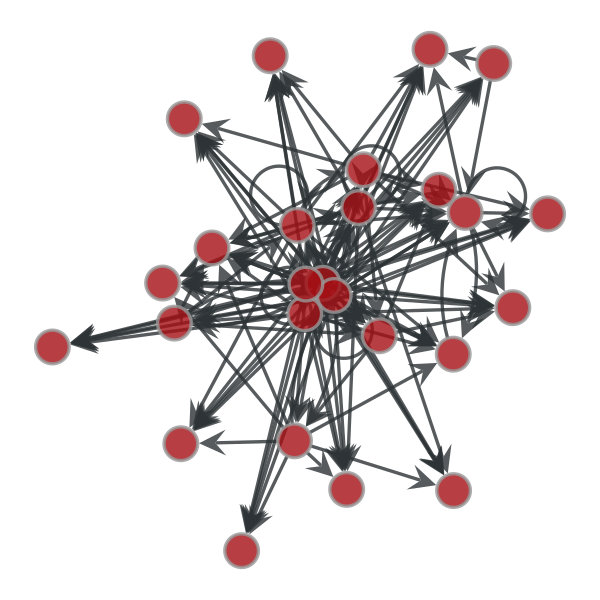

<PropertyMap object with key type 'Vertex' and value type 'vector<double>', for Graph 0x7fd675f6dd10, at 0x7fd6503d8350>

In [139]:
import graph_tool.draw

## Broken
#state = minimize_nested_blockmodel_dl(g, deg_corr=True)
#state.draw(output="power_nested_mdl.pdf")
pos = arf_layout(g, max_iter=0)
graph_draw(g, pos=pos, output="graph-draw-radial.pdf")

## Try parsing the shitty real data

In [612]:
import pandas as pd
import re
import sys
from collections import Counter, OrderedDict

def get_addy_from_field(line):
    ## regex for "finding" an email address in a string
    ## Stolen from the internet, maybe it works
    ## It works pretty good!
    ## Thanks: https://gist.github.com/dideler/5219706
    regex = re.compile(("([a-z0-9!#$%&'*+\/=?^_`{|}~-]+(?:\.[a-z0-9!#$%&'*+\/=?^_`"
                        "{|}~-]+)*(@|\sat\s)(?:[a-z0-9](?:[a-z0-9-]*[a-z0-9])?(\.|"
                        "\sdot\s))+[a-z0-9](?:[a-z0-9-]*[a-z0-9])?)"))
    adds = re.findall(regex, line)
    ## If no matches adds will be empty
    try:
        if len(adds) >= 1:
            adds = [x[0].strip() for x in adds]
    except Exception as inst:
        print(adds, inst)
    return adds
    

fields = OrderedDict({"from":"People_Email From", "to":"People_Email To", "cc":"People_Email CC", "bcc":"People_Email BCC"})
## Read the raw
df = pd.read_csv("allemailfull.csv")

## Or just do a subset for testing
#df = pd.read_csv("subset.csv")

## Just get the columns we want
df = df.filter(items=[fields["from"], fields["to"], fields["cc"], fields["bcc"]], axis=1)
df = df.fillna(value="")
#print(df.head())


bad_addys = Counter()
from_email = {}

tot_emails = 0
no_sender_count = 0
for row in df.head(250000).itertuples():
    tot_emails += 1
    if not tot_emails % 50000:
        print(tot_emails),
    try:
        idx, sender, receiver, cc, bcc = row
        #print(row) 
    except Exception as inst:
        print(inst, row)
    try:
        sender = get_addy_from_field(sender)
        ## If you haven't seen this sender before then add the to/cc/bcc dicts
        if not sender:
            no_sender_count += 1
            continue
        if not from_email.get(sender[0]):
            #print("Adding new sender - {}".format(sender[0]))
            from_email[sender[0]] = {"to":Counter(), "cc":Counter(), "bcc":Counter()}

        ## For each receiver (To: field can be multiple) update the count for this sender
        for recv in get_addy_from_field(receiver):
            from_email[sender[0]]["to"].update([recv])
        ## For each cc: update the counts
        for c in get_addy_from_field(cc):
            from_email[sender[0]]["cc"].update([c])
        ## For each bcc: update the counts
        for bc in get_addy_from_field(bcc):
            from_email[sender[0]]["bcc"].update([bc])

    except Exception as inst:
        print(inst, sender, recv, cc, bcc)
        if sender:
            ## Empty From: field if sender is empty
            bad_addys.update([sender[0]])

## Post process to get the list of all unique emails either To: or From:
all_senders = from_email.keys()
all_receivers = []
[all_receivers.extend(from_email[x]["to"]) for x in all_senders]
[all_receivers.extend(from_email[x]["cc"]) for x in all_senders]
[all_receivers.extend(from_email[x]["bcc"]) for x in all_senders]
all_receivers.extend(all_senders)
all_users = set(all_receivers)
#print(all_users)

print("Total emails processed - {}".format(tot_emails))
print("Number of emails w/o From: field - {}".format(no_sender_count))
print("Number of unique From: fields - {}".format(len(from_email.keys())))
print("Number of unique addresses total - {}".format(len(all_users)))
print("Number of bad From: fields - {}".format(len(bad_addys.keys())))
print("\t{}".format(bad_addys.values()))
## Don't do this on big data or it'll crush your notebook
#print(from_email)

50000 100000 150000 200000 250000 Total emails processed - 250000
Number of emails w/o From: field - 62
Number of unique From: fields - 690
Number of unique addresses total - 8335
Number of bad From: fields - 0
	[]


In [407]:
print(from_email["agrant@hughescom.com"]["to"])
print(from_email["kschmoll@hughescm.com"]["to"])
#print([x["to"] for x in from_email.values()[:2]])

Counter({'agrant@hughescom.com': 6})
Counter({'kschmoll@hughescm.com': 21, 'kangulug@nbc.co.za': 2, 'atysonjett@bandcassociates.com': 2})


<Graph object, undirected, with 8335 vertices and 8397 edges at 0x7fd5c00609d0>
<Graph object, undirected, with 143 vertices and 845 edges, edges filtered by (<PropertyMap object with key type 'Edge' and value type 'bool', for Graph 0x7fd5c00609d0, at 0x7fd5c1174050>, False), vertices filtered by (<PropertyMap object with key type 'Vertex' and value type 'bool', for Graph 0x7fd5c00609d0, at 0x7fd5c13b1fd0>, False) at 0x7fd5c00609d0>


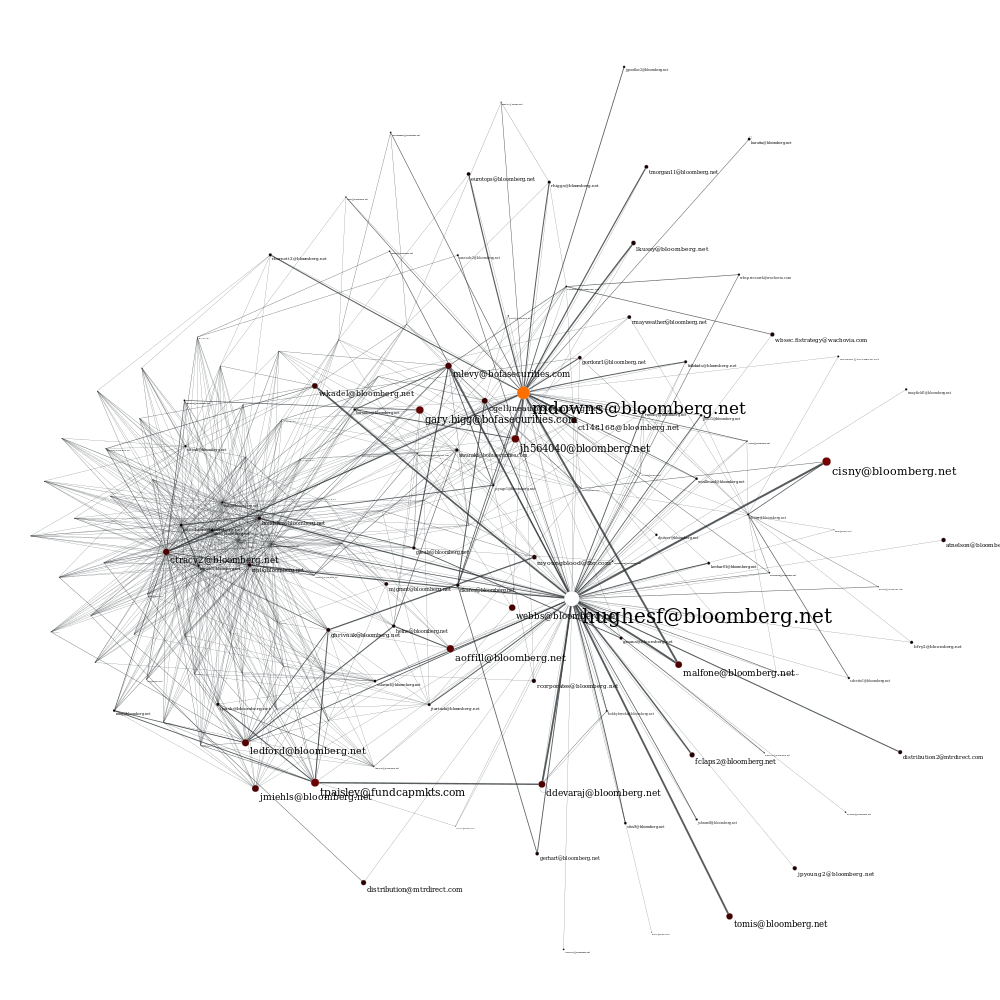

<PropertyMap object with key type 'Vertex' and value type 'vector<double>', for Graph 0x7fd5c00609d0, at 0x7fd5c061d390>


In [745]:
from graph_tool.all import *

## dict for user to vertex mapping
users = {}
min_degree = 10
do_cc = True

## Undirected graph gives somewhat more interpretable results
g = Graph(directed=False)
labels = g.new_vertex_property("string")
for user in all_users:
    v = g.add_vertex()
    users[user] = v
    labels[v] = user
weight = g.new_edge_property("double")

## Just look at the To: field
for sender in from_email.keys():
    for to in from_email[sender]["to"].keys():
        if from_email[sender]["to"][to] > min_degree:
            e = g.add_edge(users[sender], users[to])
            weight[e] = from_email[sender]["to"][to]
if do_cc:
    ## Include cc: field
    for sender in from_email.keys():
        for to in from_email[sender]["cc"].keys():
            if from_email[sender]["cc"][to] > min_degree:
                e = g.add_edge(users[sender], users[to])
                weight[e] = from_email[sender]["cc"][to]

vp, ep = betweenness(g, weight=weight)
print(g)

d = g.degree_property_map("total")
periphery = g.new_vertex_property("bool")
periphery.a = d.a >= min_degree
g.set_vertex_filter(periphery)
print(g)

## C increases the relative repulsive force. Default is 0.2
## p is the repulsive force exponent, default is 2, maybe doesn't make much difference
pos = sfdp_layout(g, C=.5, p=2)

## arf layout is also somewhat nice, the rest are useless
#pos = arf_layout(g, dim=2)

#g.purge_vertices()
p = graph_draw(g, output_size=(1000, 1000),
    pos=pos,
    vertex_fill_color=vp,
    ## Smaller values of power reduce the difference between the big and small vertices
    ## 0.5 is default
    vertex_size=prop_to_size(vp, mi=0, ma=15, power=0.5),
    edge_pen_width=prop_to_size(ep, mi=0.2, ma=2),
    vcmap=plt.cm.gist_heat,
    vorder=vp,
    vertex_text=labels,
    vertex_font_size=prop_to_size(vp, mi=0, ma=20, power=0.5),
    vertex_text_position=1,
    ## The fit view param has to be tweaked if you change the data
    ## This doesn't work as well as fit view with a float (as below)
    #fit_view=(20, 20, 60, 60),
    fit_view=2,
    output="betweenness.png")
print(p)

187325.32663


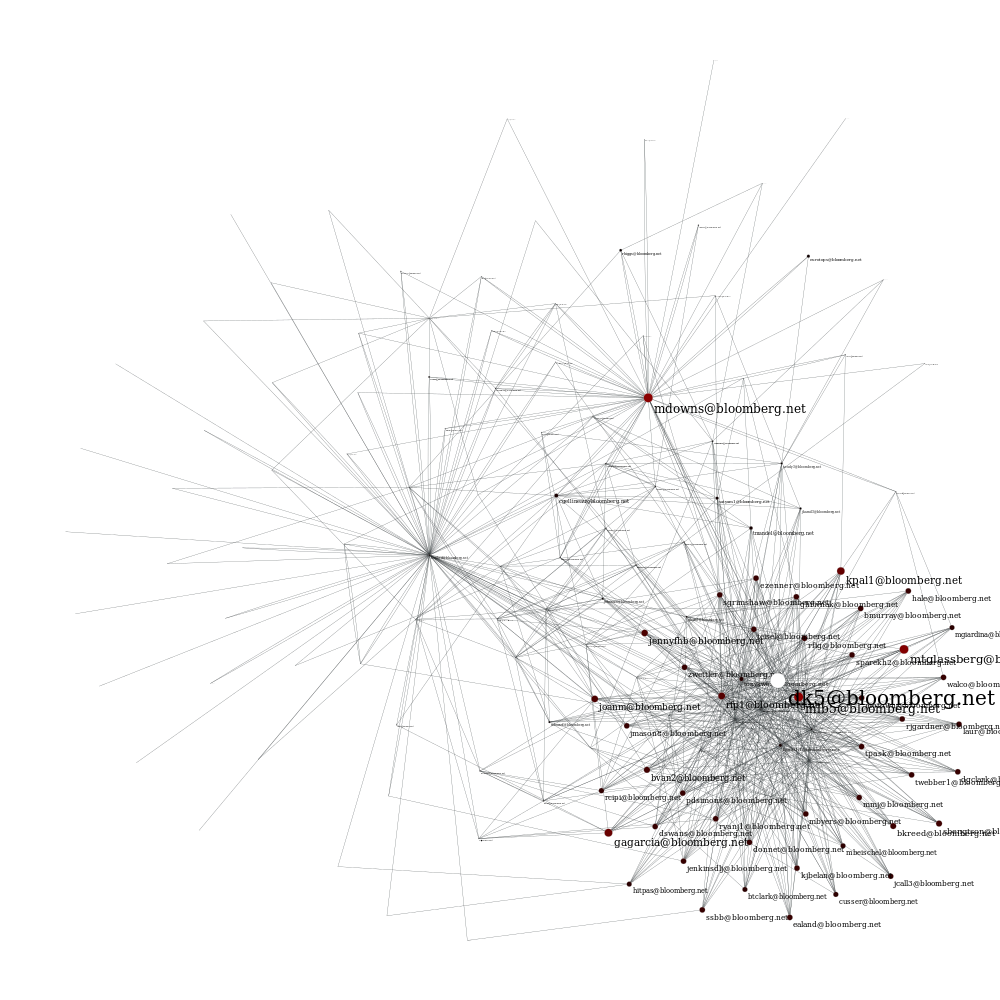

<PropertyMap object with key type 'Vertex' and value type 'vector<double>', for Graph 0x7fd5b06f3290, at 0x7fd5c06375d0>

In [614]:

ee, x = eigenvector(g, weight=weight)
print(ee)
graph_draw(g, output_size=(1000, 1000),
            vertex_fill_color=x,
            vertex_size=prop_to_size(x, mi=0, ma=15),
            vcmap=plt.cm.gist_heat,
            vorder=x,
            vertex_text=labels,
            vertex_font_size=prop_to_size(x, mi=0, ma=20, power=0.5),
            vertex_text_position=1,
            fit_view=2,
            output="eigenvector.png")

## Lets just look at a subset by either selectively adding individuals or selectively dropping them

<Graph object, undirected, with 8335 vertices and 9401 edges at 0x7fd6663efbd0>
<Graph object, undirected, with 374 vertices and 1981 edges, edges filtered by (<PropertyMap object with key type 'Edge' and value type 'bool', for Graph 0x7fd6663efbd0, at 0x7fd5c0202210>, False), vertices filtered by (<PropertyMap object with key type 'Vertex' and value type 'bool', for Graph 0x7fd6663efbd0, at 0x7fd5c02023d0>, False) at 0x7fd6663efbd0>


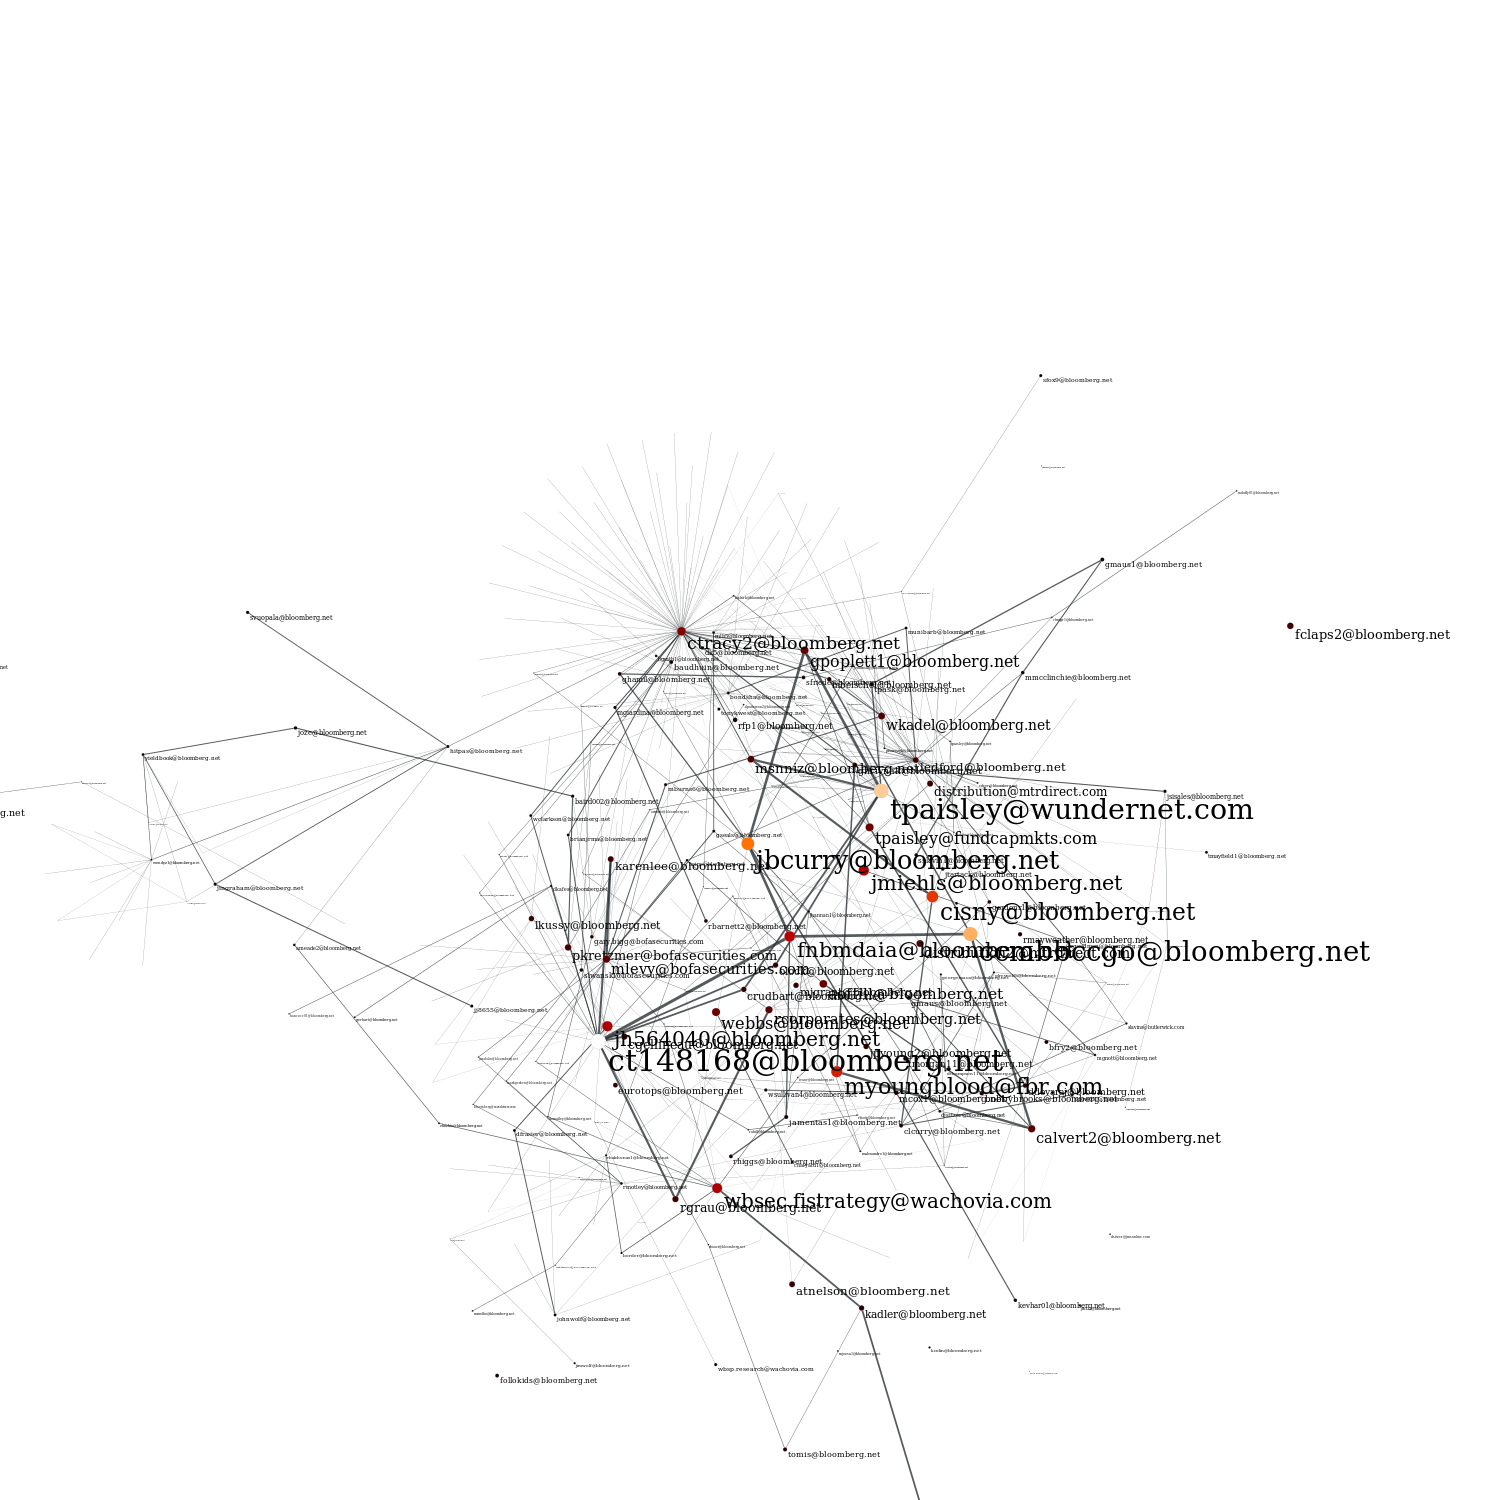

In [841]:
from graph_tool.all import *

## drop_users will interpret the subset list as users to drop rather than users to add
def view_subset(subset, do_cc=False, min_degree=4, min_weight=10, drop_users=False, min_font_size=0, btwn=True, fit_view=1):
    ## dict for user to vertex mapping
    users = {}
    min_degree = min_degree
    min_weight = min_weight
    do_cc = do_cc

    ## Undirected graph gives somewhat more interpretable results
    g = Graph(directed=False)
    labels = g.new_vertex_property("string")
    for user in all_users:
        v = g.add_vertex()
        users[user] = v
        labels[v] = user
    weight = g.new_edge_property("double")

    ## Just look at the To: field
    for sender in from_email.keys():
        for to in from_email[sender]["to"].keys():
            if drop_users == True:
                if sender in subset or to in subset:
                    continue
                else:
                    if from_email[sender]["to"][to] >= min_degree:
                        e = g.add_edge(users[sender], users[to])
                        weight[e] = from_email[sender]["to"][to]
            if from_email[sender]["to"][to] >= min_degree:
                if sender in subset or to in subset:
                    e = g.add_edge(users[sender], users[to])
                    weight[e] = from_email[sender]["to"][to]

    if do_cc:
        ## Include cc: field
        for sender in from_email.keys():
            for to in from_email[sender]["cc"].keys():
                if drop_users == True:
                    if sender in subset or to in subset:
                        continue
                    else:
                        if from_email[sender]["cc"][to] >= min_degree:
                            e = g.add_edge(users[sender], users[to])
                            weight[e] = from_email[sender]["cc"][to]
                if from_email[sender]["cc"][to] >= min_degree:
                    if sender in subset or to in subset:
                        e = g.add_edge(users[sender], users[to])
                        weight[e] = from_email[sender]["cc"][to]

    if btwn:
        vp, ep = betweenness(g, weight=weight)
    else:
        ee, vp = eigenvector(g, weight=weight)
        ep = g.new_edge_property("double", vals=weight)
    print(g)

    d = g.degree_property_map("total")
    periphery = g.new_vertex_property("bool")
    periphery.a = d.a >= min_degree
    ## This should filter on min weight per edge but it doesn't work
    minweight = g.new_edge_property("bool")
    minweight.a = weight >= min_weight
    g.set_vertex_filter(periphery)
    g.set_edge_filter(minweight)
    print(g)

    ## C increases the relative repulsive force. Default is 0.2
    ## p is the repulsive force exponent, default is 2, maybe doesn't make much difference
    pos = sfdp_layout(g, C=.2, p=2)

    ## arf layout is also somewhat nice, the rest are useless
    #pos = arf_layout(g, dim=2)

    #g.purge_vertices()
    p = graph_draw(g, output_size=(1500, 1500),
        pos=pos,
        vertex_fill_color=vp,
        ## Smaller values of power reduce the difference between the big and small vertices
        ## 0.5 is default
        vertex_size=prop_to_size(vp, mi=0, ma=15, power=0.5),
        edge_pen_width=prop_to_size(ep, mi=0, ma=3),
        vcmap=plt.cm.gist_heat,
        vorder=vp,
        vertex_text=labels,
        vertex_font_size=prop_to_size(vp, mi=min_font_size, ma=30, power=0.5),
        vertex_text_position=1,
        ## The fit view param has to be tweaked if you change the data
        ## This doesn't work as well as fit view with a float (as below)
        #fit_view=(20, 20, 60, 60),
        fit_view=fit_view,
        output="dropped.png")
#view_subset(["hughesf@bloomberg.net", "mdowns@bloomberg.net"], min_degree=2, min_font_size=5, do_cc=False)
#view_subset(["hughesf@bloomberg.net", "mdowns@bloomberg.net"], min_degree=10, min_font_size=0, drop_users=True)
view_subset(["hughesf@bloomberg.net", "mdowns@bloomberg.net"], min_degree=5, min_font_size=0, 
                                                                fit_view=3, drop_users=True, btwn=True)
#view_subset(["hughesf@bloomberg.net", "mdowns@bloomberg.net", "dk5@bloomberg.net"], min_degree=1, fit_view=1.5, do_cc=True, btwn=True)


## Testing

## Lets look at non bloomberg emails

<Graph object, undirected, with 8335 vertices and 57 edges at 0x7fd5c027fd50>
<Graph object, undirected, with 44 vertices and 57 edges, edges filtered by (<PropertyMap object with key type 'Edge' and value type 'bool', for Graph 0x7fd5c027fd50, at 0x7fd5c01ec890>, False), vertices filtered by (<PropertyMap object with key type 'Vertex' and value type 'bool', for Graph 0x7fd5c027fd50, at 0x7fd5c03fc250>, False) at 0x7fd5c027fd50>


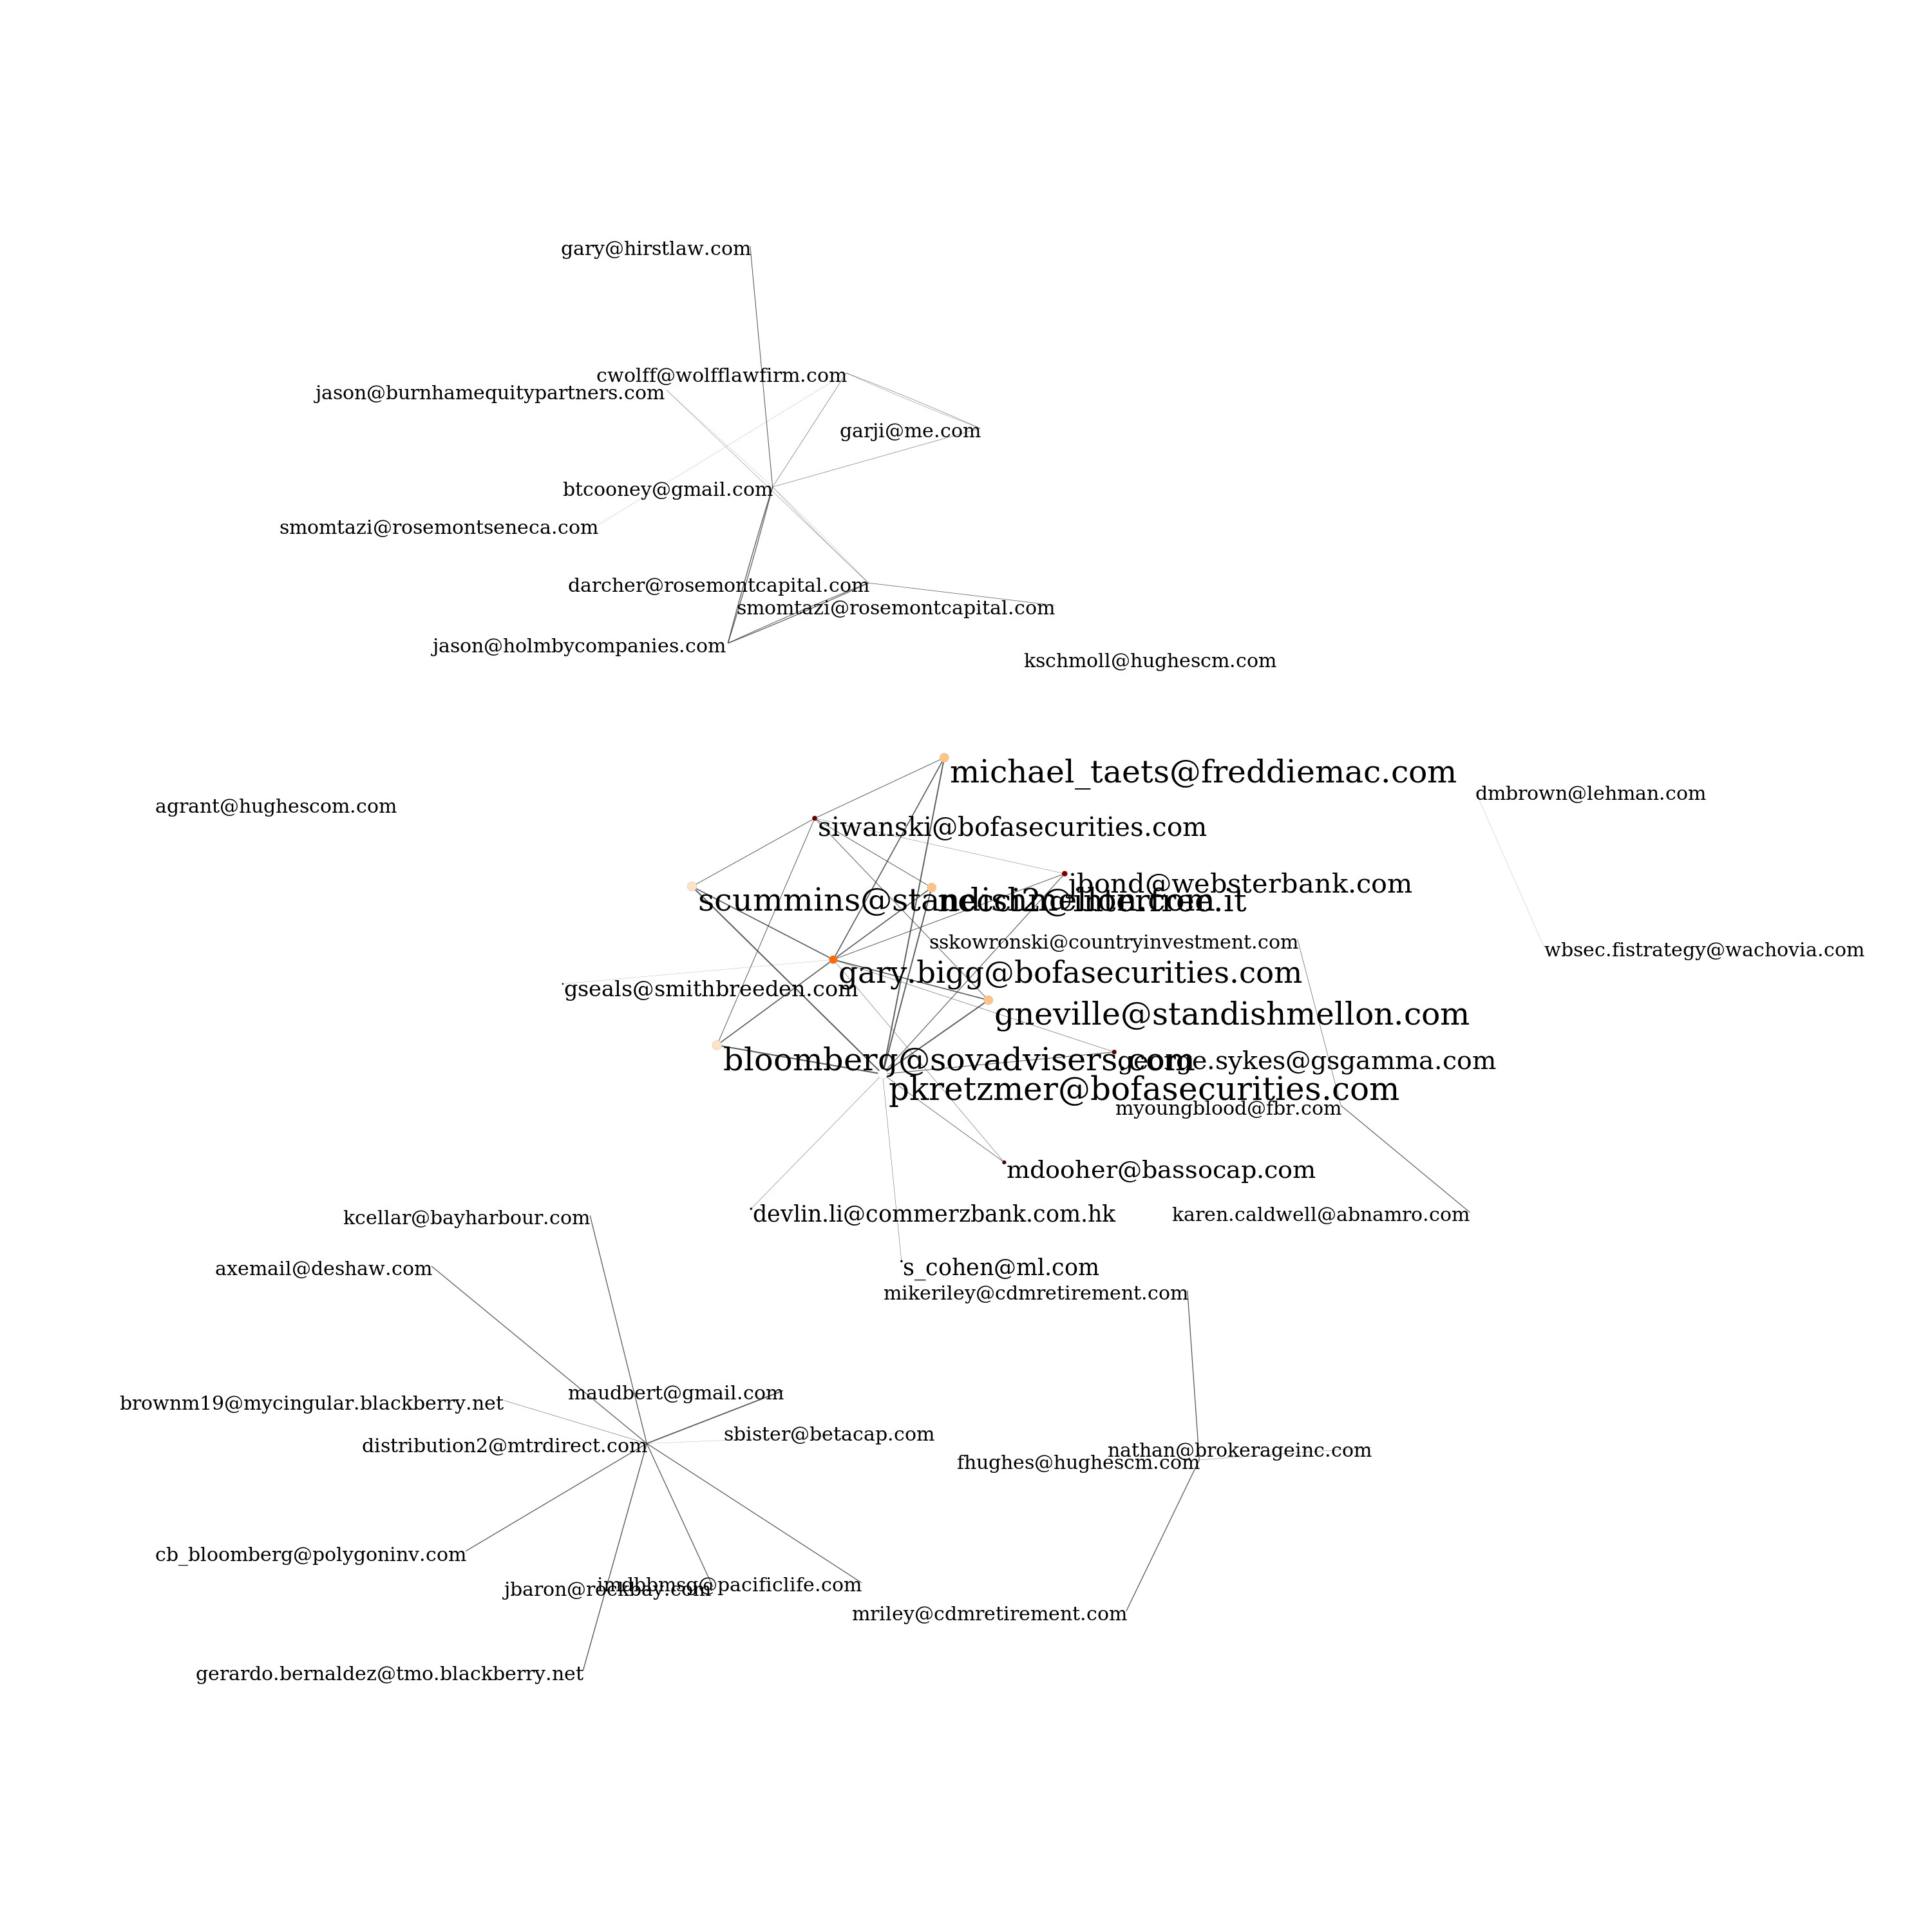

<PropertyMap object with key type 'Vertex' and value type 'vector<double>', for Graph 0x7fd5c027fd50, at 0x7fd5c01ecb50>


In [837]:
from graph_tool.all import *
## subset will include any bloomberg emails to keep, if you like
def drop_bloombergs(subset, btwn=True, min_degree=1, min_weight=10, do_cc=False):
    ## dict for user to vertex mapping
    users = {}
    min_degree = min_degree
    do_cc = do_cc

    ## Undirected graph gives somewhat more interpretable results
    g = Graph(directed=False)
    labels = g.new_vertex_property("string")
    for user in all_users:
        v = g.add_vertex()
        users[user] = v
        labels[v] = user
    weight = g.new_edge_property("double")

    ## Just look at the To: field
    for sender in from_email.keys():
        for to in from_email[sender]["to"].keys():
            if "bloomberg.net" in sender or "bloomberg.net" in to:
                continue
            if from_email[sender]["to"][to] > min_weight:
                e = g.add_edge(users[sender], users[to])
                weight[e] = from_email[sender]["to"][to]
    if do_cc:
        ## Include cc: field
        for sender in from_email.keys():
            for to in from_email[sender]["cc"].keys():
                if from_email[sender]["cc"][to] > min_weight:
                    e = g.add_edge(users[sender], users[to])
                    weight[e] = from_email[sender]["cc"][to]

    if btwn:
        vp, ep = betweenness(g, weight=weight)
    else:
        ee, vp = eigenvector(g, weight=weight)
        ep = g.new_edge_property("double", vals=weight)
    print(g)

    d = g.degree_property_map("total")
    periphery = g.new_vertex_property("bool")
    periphery.a = d.a >= min_degree
    g.set_vertex_filter(periphery)
    print(g)

    ## C increases the relative repulsive force. Default is 0.2
    ## p is the repulsive force exponent, default is 2, maybe doesn't make much difference
    pos = sfdp_layout(g, C=.5, p=5)

    ## arf layout is also somewhat nice, the rest are useless
    #pos = arf_layout(g, dim=2)

    #g.purge_vertices()
    p = graph_draw(g, output_size=(3000, 3000),
        pos=pos,
        vertex_fill_color=vp,
        ## Smaller values of power reduce the difference between the big and small vertices
        ## 0.5 is default
        vertex_size=prop_to_size(vp, mi=0, ma=15, power=0.5),
        edge_pen_width=prop_to_size(ep, mi=0.2, ma=2),
        vcmap=plt.cm.gist_heat,
        vorder=vp,
        vertex_text=labels,
        vertex_font_size=prop_to_size(vp, mi=30, ma=50, power=0.5),
        vertex_text_position=1,
        ## The fit view param has to be tweaked if you change the data
        ## This doesn't work as well as fit view with a float (as below)
        #fit_view=(20, 20, 60, 60),
        fit_view=1)

    print(p)
drop_bloombergs([], btwn=False, min_degree=1, min_weight=5)

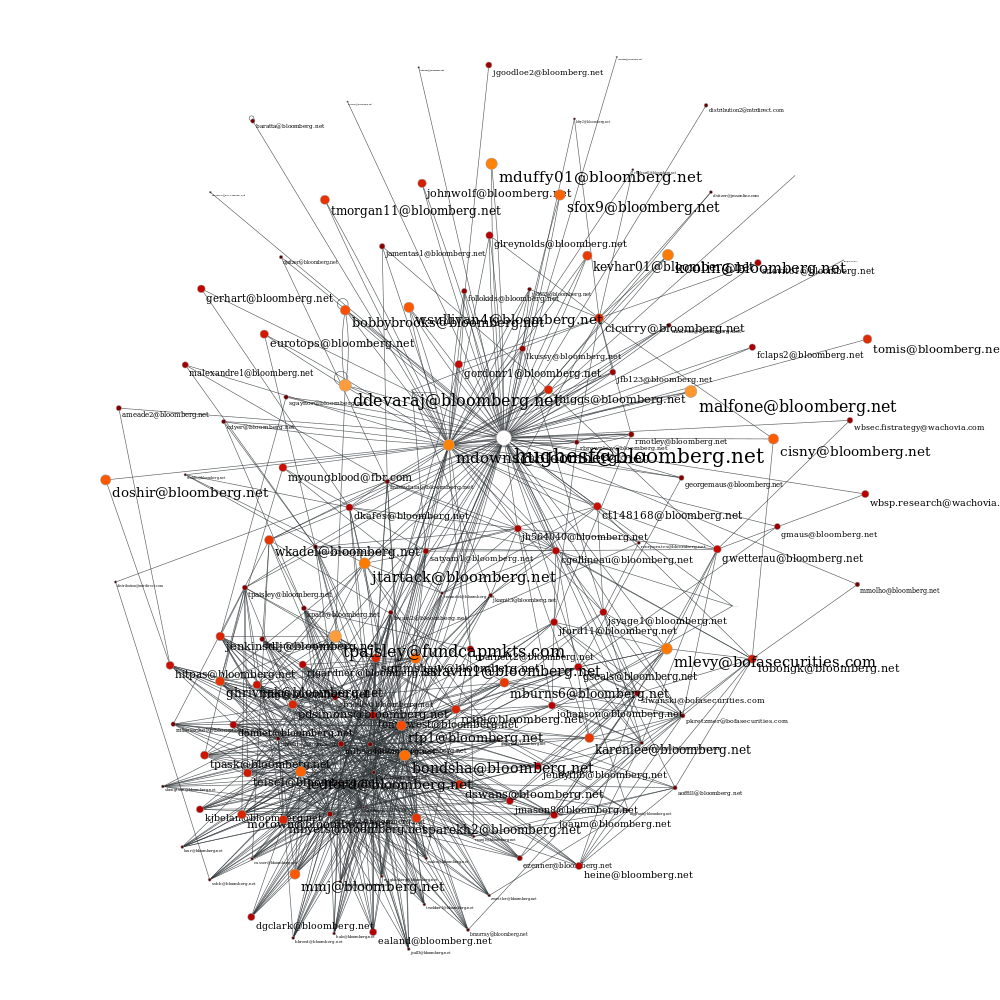

<PropertyMap object with key type 'Vertex' and value type 'vector<double>', for Graph 0x7fd5b06f3290, at 0x7fd5c1183750>

In [622]:
## Measure of "closeness". Kind of useless
x = closeness(g, weight=weight, norm=True, harmonic=True)
graph_draw(g, output_size=(1000, 1000),
            vertex_fill_color=x,
            vertex_size=prop_to_size(x, mi=0, ma=15, power=1),
            vcmap=plt.cm.gist_heat,
            vorder=x,
            vertex_text=labels,
            vertex_font_size=prop_to_size(x, mi=0, ma=20, power=1),
            vertex_text_position=1,
            fit_view=2,
            output="closeness.png")

<Graph object, undirected, with 143 vertices and 845 edges, edges filtered by (<PropertyMap object with key type 'Edge' and value type 'bool', for Graph 0x7fd5c00609d0, at 0x7fd5c1174050>, False), vertices filtered by (<PropertyMap object with key type 'Vertex' and value type 'bool', for Graph 0x7fd5c00609d0, at 0x7fd5c13b1fd0>, False) at 0x7fd5c00609d0>


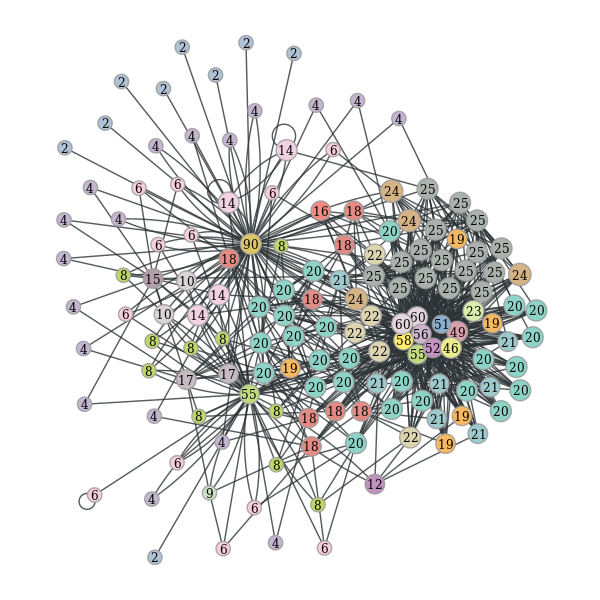

<PropertyMap object with key type 'Vertex' and value type 'vector<double>', for Graph 0x7fd5c00609d0, at 0x7fd5c0e7bf10>

In [750]:
## Also useless
print(g)
kcore = kcore_decomposition(g)
graph_draw(g, vertex_fill_color=kcore, vertex_text=kcore)

In [540]:
minx = np.min([x[0] for x in p])
maxx = np.max([x[0] for x in p])
miny = np.min([x[1] for x in p])
maxy = np.max([x[1] for x in p])
print(minx, maxx, miny, maxy)

(-9.4388207764172272, 95.224116682980352, -19.478790751679945, 41.733346131880509)


# Lets do everything the "right" way

## There's gotta be a better way to store the data

In [1046]:

def get_addy_from_field(line):
    ## regex for "finding" an email address in a string
    ## Stolen from the internet, maybe it works
    ## It works pretty good!
    ## Thanks: https://gist.github.com/dideler/5219706
    regex = re.compile(("([a-z0-9!#$%&'*+\/=?^_`{|}~-]+(?:\.[a-z0-9!#$%&'*+\/=?^_`"
                        "{|}~-]+)*(@|\sat\s)(?:[a-z0-9](?:[a-z0-9-]*[a-z0-9])?(\.|"
                        "\sdot\s))+[a-z0-9](?:[a-z0-9-]*[a-z0-9])?)"))
    adds = re.findall(regex, line)
    ## If no matches adds will be empty
    try:
        if len(adds) == 0:
            adds = ["empty"]
        elif len(adds) >= 1:
            adds = [x[0].strip() for x in adds]

    except Exception as inst:
        print(adds, inst)
    return adds
    

fields = OrderedDict({"from":"People_Email From", "to":"People_Email To", "cc":"People_Email CC",\
                      "bcc":"People_Email BCC", "subject":"Meta_Document Subject", "date":"DT_Date Sent"})
## Read the raw
#df = pd.read_csv("allemailfull.csv")

## Or just do a subset for testing
df = pd.read_csv("subset.csv")

## Just get the columns we want
df = df.filter(items=[fields["from"], fields["to"], fields["cc"], fields["bcc"], fields["subject"], fields["date"]], axis=1)
df = df.fillna(value="")

df[fields['from']] = df[fields['from']].map(lambda x: get_addy_from_field(x)[0])
df[fields['to']] = df[fields['to']].map(lambda x: get_addy_from_field(x))
df[fields['cc']] = df[fields['cc']].map(lambda x: get_addy_from_field(x))
df[fields['bcc']] = df[fields['bcc']].map(lambda x: get_addy_from_field(x))

all_senders = set([x for x in df[fields["from"]]])

## Getting all receivers is more of a hassle
tmplist = df[[fields["to"], fields["cc"], fields["bcc"]]].values
all_receivers = set(chain.from_iterable([chain.from_iterable(x) for x in newlist]))

all_users = all_senders.union(all_receivers)

print("# emails\t{}".format(len(df)))
print("# senders\t{}".format(len(all_senders)))
print("# receivers\t{}".format(len(all_receivers)))
print("Total users\t{}".format(len(all_users)))

# emails	9999
# senders	189
# receivers	2557
Total users	2635


<Graph object, undirected, with 2635 vertices and 2501 edges at 0x7fd5c0d99c50>
<Graph object, undirected, with 218 vertices and 631 edges, edges filtered by (<PropertyMap object with key type 'Edge' and value type 'bool', for Graph 0x7fd5c0d99c50, at 0x7fd56d931510>, False), vertices filtered by (<PropertyMap object with key type 'Vertex' and value type 'bool', for Graph 0x7fd5c0d99c50, at 0x7fd56d931550>, False) at 0x7fd5c0d99c50>


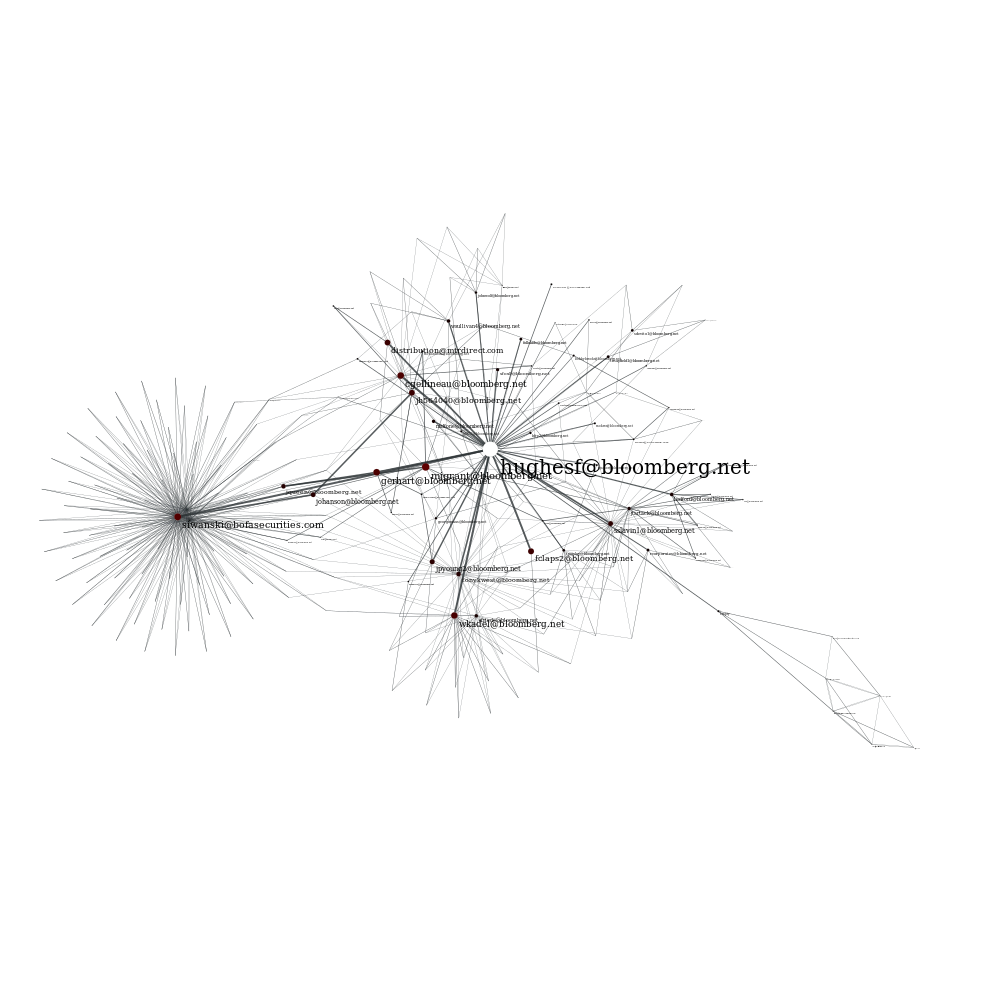

<PropertyMap object with key type 'Vertex' and value type 'vector<double>', for Graph 0x7fd5c0d99c50, at 0x7fd56d9318d0>


In [1047]:
from graph_tool.all import *

## Undirected graph gives somewhat more interpretable results
def plot_all(directed=False, min_weight=10, min_degree=3, do_cc=False, do_bcc=False, fit_view=1):
    
    ## Basic parameters
    ## minimum number of emails between individuals
    min_weight = min_weight
    ## Minimum number of connections within the network
    min_degree = min_degree
    ## Whether to include the cc lists in the network
    do_cc = do_cc
    do_bcc = do_bcc

    ## dict for user to vertex mapping, graph_tools only knows about integer indices for nodes,
    ## so we have to keep track of the node to label mapping
    users = {}

    g = Graph(directed=directed)
    labels = g.new_vertex_property("string")
    for user in all_users:
        v = g.add_vertex()
        users[user] = v
        labels[v] = user
    ## New edge property for holding edge weights
    weight = g.new_edge_property("double")


    ## Just look at the To: field
    for sender in all_senders:
        tmpdf = df.loc[(df[fields["from"]] == sender)]
        ## Get all receivers
        recvs = list(chain.from_iterable(x for x in tmpdf[fields["to"]]))
        ## Get counts per receiver
        rec_counts = Counter(recvs)
        for rec, cnt in rec_counts.items():
            if cnt > min_weight:
                e = g.add_edge(users[sender], users[rec])
                weight[e] = cnt

        if do_cc:
            ## Get all receivers
            recvs = list(chain.from_iterable(x for x in tmpdf[fields["cc"]]))
            ## Get counts per receiver
            rec_counts = Counter(recvs)
            for rec, cnt in rec_counts.items():
                if cnt > min_weight:
                    e = g.add_edge(users[sender], users[rec])
                    weight[e] = cnt
        if do_bcc:
            ## Get all receivers
            recvs = list(chain.from_iterable(x for x in tmpdf[fields["bcc"]]))
            ## Get counts per receiver
            rec_counts = Counter(recvs)
            for rec, cnt in rec_counts.items():
                if cnt > min_weight:
                    e = g.add_edge(users[sender], users[rec])
                    weight[e] = cnt

    vp, ep = betweenness(g, weight=weight)
    print(g)

    d = g.degree_property_map("total")
    periphery = g.new_vertex_property("bool")
    periphery.a = d.a >= min_degree
    g.set_vertex_filter(periphery)
    print(g)

    ## C increases the relative repulsive force. Default is 0.2
    ## p is the repulsive force exponent, default is 2, maybe doesn't make much difference
    pos = sfdp_layout(g, C=.5, p=2)

    ## arf layout is also somewhat nice, the rest are useless
    #pos = arf_layout(g, dim=2)

    #g.purge_vertices()
    p = graph_draw(g, output_size=(1000, 1000),
        pos=pos,
        vertex_fill_color=vp,
        ## Smaller values of power reduce the difference between the big and small vertices
        ## 0.5 is default
        vertex_size=prop_to_size(vp, mi=0, ma=15, power=0.5),
        edge_pen_width=prop_to_size(ep, mi=0.2, ma=2),
        vcmap=plt.cm.gist_heat,
        vorder=vp,
        vertex_text=labels,
        vertex_font_size=prop_to_size(vp, mi=0, ma=20, power=0.5),
        vertex_text_position=1,
        ## The fit view param has to be tweaked if you change the data
        ## This doesn't work as well as fit view with a float (as below)
        #fit_view=(20, 20, 60, 60),
        fit_view=fit_view,
        output="betweenness.png")
    print(p)
plot_all(do_cc=False, min_degree=3, min_weight=4, fit_view=2)

In [1005]:
tmpdf = df.loc[(df[fields["from"]] == "agrant@hughescom.com")]
recvs = list(chain.from_iterable(x for x in tmpdf[fields["to"]]))
print(tmpdf)
print(recvs)

       People_Email From         People_Email To People_Email CC  \
1   agrant@hughescom.com  [agrant@hughescom.com]         [empty]   
13  agrant@hughescom.com  [agrant@hughescom.com]         [empty]   
35  agrant@hughescom.com  [agrant@hughescom.com]         [empty]   
40  agrant@hughescom.com  [agrant@hughescom.com]         [empty]   
41  agrant@hughescom.com  [agrant@hughescom.com]         [empty]   
47  agrant@hughescom.com  [agrant@hughescom.com]         [empty]   

   People_Email BCC                  Meta_Document Subject DT_Date Sent  
1           [empty]  Microsoft Office Outlook Test Message               
13          [empty]  Microsoft Office Outlook Test Message               
35          [empty]  Microsoft Office Outlook Test Message               
40          [empty]  Microsoft Office Outlook Test Message               
41          [empty]  Microsoft Office Outlook Test Message               
47          [empty]  Microsoft Office Outlook Test Message               
['agr